# Classification. Linear models and KNN

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [4]:
PATH = "./data/"

In [5]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [6]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [7]:
males = data['Sex'].value_counts()['male']
females = data['Sex'].value_counts()['female']
survived = data['Survived'].value_counts()[1]
survived_females = data.groupby(['Sex']).sum()['Survived']['female']
survived_males = data.groupby(['Sex']).sum()['Survived']['male']
print(f'There are {males} maleas and {females} females on the ship.')
print(f'Survived {survived} peoples: {survived_males} males and {survived_females} females.')

There are 577 maleas and 314 females on the ship.
Survived 342 peoples: 109 males and 233 females.


There are almost two times more males than females. But survival rate of males is way lower. <br>
$\ R_{male} = \frac{109} {577} \times {100}\% = 18.89\% $ <br>
$\ R_{female} = \frac{233} {314} \times {100}\% = 74.20\% $ <br>

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

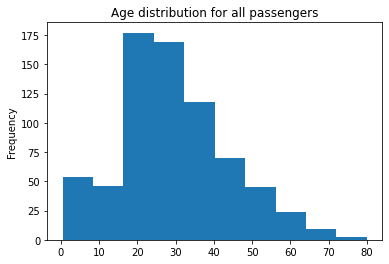

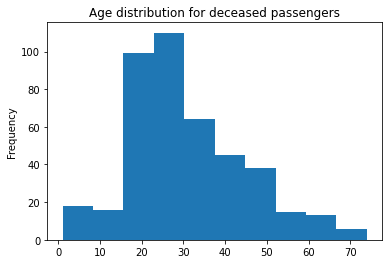

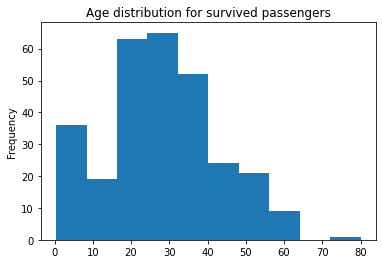

In [8]:
def draw_age_series(series, title=None):
    series.plot.hist()
    if title:
        plt.title(title)
    plt.show()
    
draw_age_series(data['Age'], 'Age distribution for all passengers')
draw_age_series(data[data['Survived'] == 0]['Age'], 'Age distribution for deceased passengers')
draw_age_series(data[data['Survived'] == 1]['Age'], 'Age distribution for survived passengers')

Age distribution is more or less the same. The only significant difference is that we have **more younger passengers** and **less elders** among survivors.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [9]:
def calculate_survival_data(df, feature, feature_value):
    feature_df = df[df[feature] == feature_value]
    total = feature_df.shape[0]
    survived = feature_df[feature_df['Survived'] == 1].shape[0]
    return (total, survived)

barWidth = 0.25

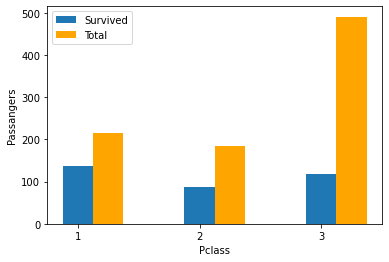

In [10]:
pclass_total = []
pclass_survived = []
pclasses = np.sort(data['Pclass'].unique())

for pclass in pclasses:
    total, survived = calculate_survival_data(data, 'Pclass', pclass)
    pclass_total.append(total)
    pclass_survived.append(survived)

    
br1 = np.arange(len(pclass_total))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, pclass_survived, width=barWidth)
plt.bar(br2, pclass_total, color='orange', width=barWidth)
plt.xlabel('Pclass')
plt.ylabel('Passangers')
plt.xticks(range(len(pclasses)), pclasses)
plt.legend(['Survived', 'Total'])
plt.show()

As we can see from the plot **the most safe calss if 1st class** and **the least safe is 3rd class**.

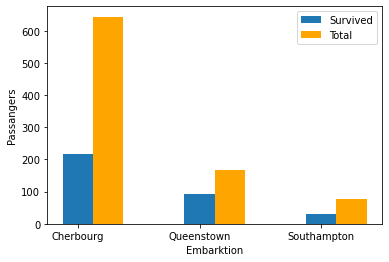

In [11]:
embarktions = data['Embarked'].fillna(data['Embarked'].mode()[0]).unique()
embarktion_total = []
embarktion_survived = []

for embarktion in embarktions:
    total, survived = calculate_survival_data(data, 'Embarked', embarktion)
    embarktion_total.append(total)
    embarktion_survived.append(survived)
    
br1 = np.arange(len(embarktion_total))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
    
plt.bar(br1, embarktion_survived, width=barWidth)
plt.bar(br2, embarktion_total, color='orange', width=barWidth)
plt.xlabel('Embarktion')
plt.ylabel('Passangers')
plt.xticks(range(len(embarktions)), ['Cherbourg', 'Queenstown', 'Southampton'])
plt.legend(['Survived', 'Total'])
plt.show()

This correlation is not very clear but the best chances for survival is for passengers which embarked in Queenstown, the worst - Cherbourg.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [12]:
for col in data.columns:
    print(f'{col}: {round(data[col].isnull().sum() / data.shape[0] * 100, 2)}%')

Survived: 0.0%
Pclass: 0.0%
Name: 0.0%
Sex: 0.0%
Age: 19.87%
SibSp: 0.0%
Parch: 0.0%
Ticket: 0.0%
Fare: 0.0%
Cabin: 77.1%
Embarked: 0.22%


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

**Age** <br>
We can use mean value to fill empty age slots. Advatage - easy to implemet.

**Cabin** <br>
We can transfom cabin number feature into categorical feature that represents if passages has a cabin. Advantage - easy to implement.

**Embarked** <br>
I guess the best solution is to just drop empty data as we only have 2 passangers without this data. Another solution would be to use mode value of embarked feature.

In [13]:
data['Age'] = data.Age.fillna(data['Age'].mean())
data['HasCabin'] = data.Cabin.apply(lambda x: 0 if pd.isnull(x) else 1)
data.dropna(subset=['Embarked'], inplace=True)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [14]:
y_feature = 'Survived'
x_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasCabin']
y = data[y_feature]

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[x_features])

lr = LogisticRegression()
cv = cross_val_score(lr, data_scaled, data[y_feature], cv=5, scoring='accuracy')
print(f'Linear regression score: {cv.mean()}')

Linear regression score: 0.7053513616454008


In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
cv = cross_val_score(kmeans, data_scaled, data[y_feature], cv=5, scoring='accuracy')
print(f'KMeans score: {cv.mean()}')

KMeans score: 0.6929727670919824


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [17]:
data['IsMale'] = data.Sex.apply(lambda x: 1 if x == 'male' else 0)
data['EmbarkedNum'] = data.Embarked.apply(lambda x: 0 if x == 'C' else 1 if x == 'Q' else 2)

x_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasCabin', 'IsMale', 'EmbarkedNum']

data_scaled = scaler.fit_transform(data[x_features])

lr = LogisticRegression()
cv = cross_val_score(lr, data_scaled, data[y_feature], cv=5, scoring='accuracy')
print(f'Linear regression score: {cv.mean()}')

Linear regression score: 0.7896781565416111


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [18]:
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
test['Age'] = test.Age.fillna(data['Age'].mean())
test['HasCabin'] = test.Cabin.apply(lambda x: 0 if pd.isnull(x) else 1)
test.dropna(subset=['Embarked'], inplace=True)
test['IsMale'] = test.Sex.apply(lambda x: 1 if x == 'male' else 0)
test['EmbarkedNum'] = test.Embarked.apply(lambda x: 0 if x == 'C' else 1 if x == 'Q' else 2)
test['Fare'] = test.Fare.fillna(test['Fare'].mean())
test_scaled = scaler.fit_transform(test[x_features])

lr.fit(data_scaled, data[y_feature])
predicted = lr.predict(test_scaled)
submission = pd.DataFrame({'PassengerId': test.index, 'Survived': predicted})
submission.to_csv('submission.csv', index =False)

**Kaggle score:** 0.76555

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [19]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [20]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [21]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [22]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [25]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

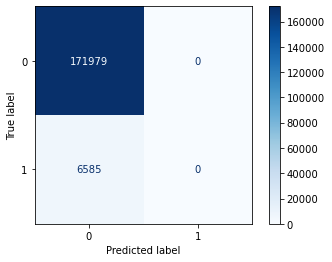

In [26]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [27]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

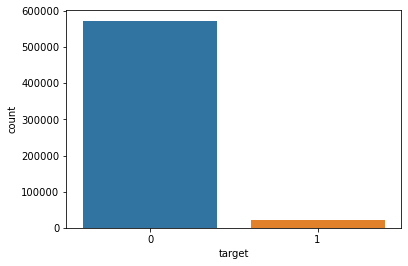

In [28]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [29]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

Other metrics: precision, recall, F1 score

Let's calculate the Normalized Gini Coefficient:

In [30]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [31]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

****Random under-sampling****

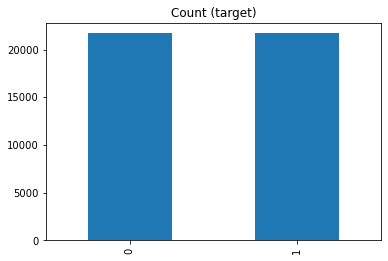

In [39]:
count_class_0, count_class_1 = insurance_data.target.value_counts()

df_class_0 = insurance_data[insurance_data['target'] == 0]
df_class_1 = insurance_data[insurance_data['target'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

****Random over-sampling****

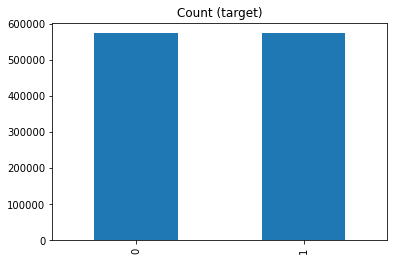

In [40]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');